# **Creation of Chatbot with RAG and Huggingface**


**Core Goal:**

Build a domain-specific (Finance) Q&A chatbot using Huggingface's API for both embeddings and chat completions, plus Gradio for the front end.


# **BUSINESS PROBLEM DEFINITION:**

Finance companies face the challenge of consistently and efficiently training employees on complex financial concepts and ensuring they remain updated on ever-evolving business laws. This leads to:

*   **Inconsistent Training**: Traditional training methods can be time-consuming, expensive, and may not reach all employees effectively
*   **Knowledge Gaps**: Employees may struggle to retain and apply complex financial information, leading to errors and compliance issues.
*   **Compliance Risks**: Staying up-to-date with changing financial regulations and business laws is crucial, but difficult to achieve manually.
*   **Time Constraints**: Employees often lack the time for extensive training sessions, impacting productivity
*   **Accessibility Issues**: Employees in remote locations or with varying schedules might face difficulty accessing training materials.

**Problems This Chatbot Can Address:**
*   On-Demand Training
*   Legal Compliance Support
*   Knowledge Reinforcement
*   Efficiency and Productivity
*   Accessibility and Scalability











# **SPECIFIC OBJECTIVES OF THE SOLUTION:**

**Training** **Objectives**:

1. **Increase Employee Knowledge Retention:**

*   Objective: Improve employee scores on post-training quizzes by 20% within the first three months of chatbot implementation.
*   Metric: Track average quiz scores before and after chatbot usage.

2. **Reduce Time to Competency**:

*   Objective: Decrease the average time it takes for new hires to demonstrate proficiency in core financial concepts by 15% within six months.
*   Metric: Measure the time taken to complete onboarding assessments.

3. **Enhance Training Accessibility**:

*  Objective: Achieve a 90% employee engagement rate with the chatbot's training modules within the first month.
*  Metric: Track the number of employees who interact with training features.

4. **Personalize Learning Paths**:

*  Objective: Have 75% of employees utilize the personalized learning path feature of the chatbot within 2 months of launch.
*  Metric: Track the usage of the personalized learning path feature.

5. **Improve employee satisfaction with training**:

* Objective: Increase employee satisfaction with training as measured by internal surveys by 10% within 4 months.
* Metric: Track employee survey results.
Legal Compliance Objectives:

**Legal Compliance Objectives**:


6. **Reduce Compliance-Related Inquiries to HR**:

* Objective: Decrease the number of compliance-related questions submitted to HR by 30% within three months.
* Metric: Track the volume of HR inquiries related to compliance.

7. **Ensure Timely Legal Updates**:

* Objective: Achieve a 100% distribution rate of critical legal updates to relevant employees within 24 hours of changes.
* Metric: Track the delivery of legal updates through the chatbot.

8. **Increase Employee Understanding of Legal Requirements**:

* Objective: Increase the score of employees on legal compliance quizzes by 15% within 3 months.
* Metric: Track employee quiz scores.

9. **Improve Audit Preparedness**:

* Objective: Maintain a complete log of employee interactions with legal information within the chatbot, readily available for audit purposes.
* Metric: Confirm the availability and accessibility of chatbot logs.

10. **Reduce Legal violation incidents**:

* Objective: Reduce the number of legal violation incidents related to employee knowledge gaps by 5% within 6 months.
* Metric: Track and analyze incidents related to legal violatons.
General Chatbot Objectives:

**General Chatbot Objectives:**


11. **Increase Chatbot Usage**:

* Objective: Achieve an average of 5 daily interactions per employee within the first month.
* Metric: Track chatbot usage statistics.

12. **Improve Chatbot Accuracy**:

* Objective: Achieve a 95% accuracy rate in answering employee questions within the first three months.
* Metric: Track the accuracy of chatbot responses.

13. **Gather User Feedback**:

* Objective: Collect feedback from at least 50% of active users within the first two months.
* Metric: Track the number of feedback submissions.

14. **Reduce Employee search time**:

* Objective: Reduce the average time employees spend searching for information by 25% within 3 months.
* Metric: Track time spent searching for information before and after implementing the chatbot.













# **DOCUMENT CORPUS:**

Following documents have been fed, which deal with finance topics:

1. Finance concepts: Includes concepts of NPV, IRR and derivatives.
2. Recent regulations: Talks about some laws realted to equity markets, derivatives and bonds.
3. Securitisation: Talks about this concept, and its role in GFC 2008.

# **PIPELINE**



**Step 1:** Install and import packages.

**Step 2:** Set your Huggingface API key.

**Step 3:** Load or create text documents.

**Step 4:** (Optional) Split documents into chunks.

**Step 5:** Create embeddings with OpenAIEmbeddings and store them in FAISS.

**Step 6:** Instantiate an OpenAI LLM with OpenAI().

**Step 7:** Define a custom prompt template to integrate conversation + retrieved chunks.

**Step 8:** Build a ConversationalRetrievalChain with memory.

**Step 9:** Ask multi-turn queries and observe how the chain fetches context from your documents.

**We have options for embeddings:**

HuggingFaceEmbeddings → OpenAIEmbeddings

HuggingFaceHub (LLM) → OpenAI (LLM)

Everything else in LangChain (splitting, vector store, retrieval chain, memory) remains the same.

# 1. Installing required packages and load them

In [89]:
!pip install langchain openai faiss-cpu pypdf


In [90]:
!pip install langchain-community

In [91]:
!pip install pymupdf

In [92]:
!pip install gradio

In [93]:
import os
import requests
import glob

from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader
from langchain.document_loaders import PyMuPDFLoader  # Import PyMuPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter

from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


In [94]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain import HuggingFaceHub
import gradio as gr


# 2. Loading PDFs

In [95]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload multiple files

# 3. Parse and Chunk the PDF Text

LangChain offers multiple loaders. PyMuPDFLoader (part of langchain.document_loaders) or a simple approach via pypdf can extract text from each PDF.

 Then we’ll split the text into smaller chunks.

# Parse the PDFs

For each PDF, we create a PyPDFLoader to load the text as Document objects.

 We’ll combine both documents into a single list.

In [96]:
# Let's assume both files are uploaded in Colab's current working directory
pdf_files = ["Securitisation.pdf", "Finance Concepts.pdf","Recent regulations.pdf"]

all_texts = []

for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file) # This line is the change
    pages = loader.load_and_split()  # Splits by page, returning a list of Documents
    for page in pages:
        # each 'page' is a Document with .page_content
        all_texts.append(page.page_content)

print(f"Loaded {len(all_texts)} document segments from PDFs.")


Loaded 9 document segments from PDFs.


# Chunking the PDF texts

Chunking in natural language processing (NLP) is a technique that breaks large text into smaller, more manageable chunks. This makes it easier to process and analyze large amounts of data

In [97]:
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=500,
    chunk_overlap=100
)

chunked_texts = []
for text in all_texts:
    chunks = text_splitter.split_text(text)
    chunked_texts.extend(chunks)

print(f"Total chunks after splitting: {len(chunked_texts)}")


Total chunks after splitting: 52


# 4. Create Embeddings and the Vector Store
Using Huggingface for embeddings:

Why we need Embeddings:


*   Semantic Understanding
*   Text Similarity and Clustering
*   Search and Information Retrieval
*   Natural Language Processing (NLP) Tasks:

In the context of the finance training chatbot embeddings allow the chatbot to understand the semantic similarity between employee questions and the training materials or legal summaries. This will then be stored as vector and passed to LLM.








In [98]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

**Storing embeddings in a vector store is crucial for**:

Speeding up similarity searches.

* Scaling to large datasets.
* Persistently storing and reusing embeddings.
* Enabling real-time search and retrieval.
* Supporting semantic search capabilities.


In [99]:
vectorstore = FAISS.from_texts(chunked_texts, embeddings)

# 5. Set Up the Huggingface LLM

We’ll use the Huggingface Facebook BART language. It is an encoder-decoder model which is suited for text summarisation and QnA. It can capture long range dependencies, develop document related understanding and handle long sequences of texts.

**Note:** Due to API call limitations with OpenAI, we preferred Huggingface LLM.

Below is the architecture of BART.

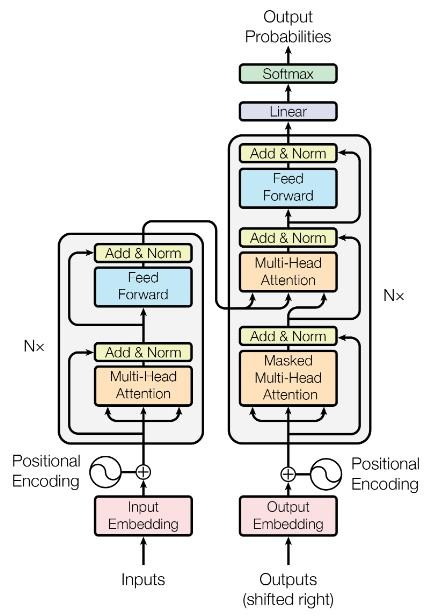

In [100]:
from google.colab import userdata
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HuggingFaceKey')

llm = HuggingFaceHub(
    repo_id="facebook/bart-large",  # Example model
    task="text-generation",  # Add this line to specify the task
    model_kwargs={"temperature": 0.7, "max_length": 512}
)

# 6. Build a Custom Prompt (Optional)


Let’s define a prompt template to incorporate retrieved context and conversation history:

In [101]:
prompt_template = """
You are a helpful AI assistant.
Use the following context to answer the user's question.
If you don't know the answer, say you don't know.

Relevant context from PDFs:
{context}

User's question: {question}

Assistant:
"""

custom_prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)


# 7. Create the Conversational Retrieval Chain

Creating a Conversational Retrieval Chain is essential for building interactive, context-aware chatbots and question-answering systems that can engage in natural and meaningful conversations. This addresses the following -



*   Contextual Understanding
*   Natural Conversation Flow
*   Enhanced Information Retrieval
*   Improved User Experience

In the context of the finance training chatbot:

Employees may ask follow-up questions or refer to previous topics. The

*   Conversational retrieval chain allows the chatbot to understand these references and provide relevant answers.
*   Complex legal or financial concepts may require multiple turns of conversation to explain fully. The chain enables the chatbot to guide employees through these concepts step by step.
*   It allows the bot to remember previous questions about specific laws, or financial concepts, so that when a related question is asked, it can provide very specific and relevant answers.

Essentially, a Conversational Retrieval Chain transforms a simple question-answering system into a dynamic and interactive conversational partner.

**Note**: Memory buffer is used to store and retireve user prompt context, which is then passed on to LLM






In [102]:
# Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# Conversational Retrieval Chain
conversational_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vectorstore.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    combine_docs_chain_kwargs={"prompt": custom_prompt},
    verbose=False
)



# 8. Integrating LLM chatbot with gradio interface for project demo

In [103]:
def predict(message, history):
    """Function to generate a response using the ConversationalRetrievalChain."""
    result = conversational_chain({"question": message})
    response = result["answer"]
    return response

In [105]:
# Create the Gradio interface
iface = gr.ChatInterface(
    fn=predict,
    title="Retrieval Chatbot",
    description="Chat with a BART-large model, grounded in retrieved documents.",
    examples=[["What is securitisation?"]],
    chatbot=gr.Chatbot(height=500),
)

# Launch the interface
iface.launch()


<ipython-input-105-4c3364d8efce>:7: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=500),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:317: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://225da06ddc5c3a110a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **REFLECTION & BUSINESS IMPACT**


1. **Memory Tracking**
   - **Functionality**: The chatbot tracks ongoing conversations, allowing trainees to reference prior learning sessions and follow up on previous topics seamlessly.
   - **Business Impact**: This fosters continuous learning, reduces redundancy, and enhances retention by providing a personalized and context-aware training experience.

2. **Retrieval of Top Chunks**
   - **Method**: The chatbot retrieves the most relevant top two document chunks for each query, ensuring high-quality responses tailored to financial topics such as regulations, risk management, and investment strategies.
   - **Business Impact**: By focusing on essential insights, trainees receive accurate and up-to-date financial knowledge, leading to better decision-making and compliance adherence.

3. **Combining Documents with Custom LLM Chain**
   - **Process**: Retrieved chunks are fed into a customized LLM (Language Learning Model) chain along with conversation history. The system then applies a tailored prompt before generating comprehensive financial training responses.
   - **Business Impact**: This structured combination enhances training accuracy, refines knowledge delivery, and ensures that employees gain well-contextualized financial insights, improving operational efficiency.

4. **Overall Business Impact**
   - **Efficiency Gains**: Automating financial training via a chatbot reduces manual training efforts and allows employees to learn at their own pace.
   - **Enhanced Decision-Making**: Providing precise, contextualized financial knowledge ensures employees make informed business decisions, reducing financial risks.
   - **Improved Employee Experience**: Continuity in training, coupled with an interactive chatbot, fosters a more engaging and seamless learning process.
   - **Scalability**: The chatbot training framework can scale across various financial domains, ensuring consistent and comprehensive learning for employees.


